In [21]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF

In [22]:
%matplotlib inline

# importing libraries
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import statsmodels.api as sm
import plotly.offline as py
import cufflinks as cf
import seaborn as sns
import pandas as pd
import numpy as np
import quandl
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Markdown, display
from matplotlib.ticker import FuncFormatter
from pandas.core.base import PandasObject
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option("display.max_rows", 10)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

# Set cufflinks offline
cf.go_offline()

#### Functions ####
def compute_drawdowns(dataframe):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    return (dataframe / dataframe.cummax() -1) * 100
    
def compute_max_DD(dataframe):
    return compute_drawdowns(dataframe).min()

def compute_cagr(dataframe, years=0):
    '''
    Function to calculate CAGR given a dataframe of prices
    '''
    years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365
    
    return (dataframe.iloc[-1].div(dataframe.iloc[0]).pow(1 / years)).sub(1).mul(100)

def compute_mar(dataframe):
    '''
    Function to calculate mar: Return Over Maximum Drawdown
    given a dataframe of prices
    '''
    return compute_cagr(dataframe).div(compute_drawdowns(dataframe).min().abs())

def compute_StdDev(dataframe, freq='days'):    
    '''
    Function to calculate annualized standart deviation
    given a dataframe of prices. It takes into account the
    frequency of the data.
    '''    
    if freq == 'days':
        return dataframe.pct_change().std().mul((np.sqrt(252))).mul(100)
    if freq == 'months':
        return dataframe.pct_change().std().mul((np.sqrt(12))).mul(100)

def compute_sharpe(dataframe, years=0, freq='days'):    
    '''
    Function to calculate the sharpe ratio given a dataframe of prices.
    '''    
    return compute_cagr(dataframe, years).div(compute_StdDev(dataframe, freq))

def compute_return(dataframe):    
    '''
    Function to calculate the sharpe ratio given a dataframe of prices.
    '''    
    return round(dataframe.iloc[-1] / dataframe.iloc[0] - 1, 4) * 100

def compute_performance_table(dataframe, years='si', freq='days'):    
    '''
    Function to calculate a performance table given a dataframe of prices.
    Takes into account the frequency of the data.
    ''' 
    
    if years == 'si':
        years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365
        
        df = pd.DataFrame([compute_cagr(dataframe, years), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe), compute_mar(dataframe)])
        df.index = ['CAGR', 'StdDev', 'Sharpe', 'Max DD', 'MAR']
        
        df = round(df.transpose(), 2)
        
        # Colocar percentagens
        df['CAGR'] = (df['CAGR'] / 100).apply('{:.2%}'.format)
        df['StdDev'] = (df['StdDev'] / 100).apply('{:.2%}'.format)
        df['Max DD'] = (df['Max DD'] / 100).apply('{:.2%}'.format)
        
        # Return object
        return df
    
    else:
        df = pd.DataFrame([compute_cagr(dataframe, years), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe), compute_mar(dataframe)])
        df.index = ['CAGR', 'StdDev', 'Sharpe', 'Max DD', 'MAR']
        
        df = round(df.transpose(), 2)
        
        # Colocar percentagens
        df['Return'] = (df['Return'] / 100).apply('{:.2%}'.format)
        df['CAGR'] = (df['CAGR'] / 100).apply('{:.2%}'.format)
        df['StdDev'] = (df['StdDev'] / 100).apply('{:.2%}'.format)
        
        # Return object
        return df

def filter_by_date(dataframe, years=0, previous_row=False):
    
    last_date = dataframe.tail(1).index
    year_nr = last_date.year.values[0]
    month_nr = last_date.month.values[0]
    day_nr = last_date.day.values[0]
            
    new_date = str(year_nr - years) + '-' + str(month_nr) + '-' + str(day_nr)
    
    if previous_row == False:
        return dataframe.loc[new_date:]
    
    elif previous_row == True:
        return pd.concat([dataframe.loc[:new_date].tail(1), dataframe.loc[new_date:]])
    
def get(quotes):

    # resample quotes to business month
    monthly_quotes = quotes.resample('BM').last()
    
    # get monthly returns
    returns = monthly_quotes.pct_change()

    # get close / first column if given DataFrame
    if isinstance(returns, pd.DataFrame):
        returns.columns = map(str.lower, returns.columns)
        if len(returns.columns) > 1 and 'close' in returns.columns:
            returns = returns['close']
        else:
            returns = returns[returns.columns[0]]

    # get returnsframe
    returns = pd.DataFrame(data={'Retornos': returns})
    returns['Ano'] = returns.index.strftime('%Y')
    returns['Mês'] = returns.index.strftime('%b')

    # make pivot table
    returns = returns.pivot('Ano', 'Mês', 'Retornos').fillna(0)

    # order columns by month
    returns = returns[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

    return returns

def plot(returns,
         title="Monthly Returns (%)",
         title_color="black",
         title_size=12,
         annot_size=10,
         figsize=None,
         cmap='RdYlGn',
         cbar=True,
         square=False):

    returns = get(returns)
    returns *= 100
    
    if figsize is None:
        size = list(plt.gcf().get_size_inches()) 
        figsize = (size[0], size[0] // 2)
        plt.close()

    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(returns, ax=ax, annot=True,
                     annot_kws={"size": annot_size}, fmt="0.2f", linewidths=0.4, center=0,
                     square=square, cbar=cbar, cmap=cmap)
    ax.set_title(title, fontsize=title_size, color=title_color, fontweight="bold")

    fig.subplots_adjust(hspace=0)
    plt.yticks(rotation=0)
    plt.show()
    plt.close()


PandasObject.get_returns_heatmap = get
PandasObject.plot_returns_heatmap = plot

def calendarize(returns):
    
    '''
    The calendarize function is an slight adaption of ranaroussi's monthly-returns-heatmap 
    You can find it here: https://github.com/ranaroussi/monthly-returns-heatmap/
    
    It turns monthly data into a 12 columns(months) and yearly row seaborn heatmap
    '''
    
    # get close / first column if given DataFrame
    if isinstance(returns, pd.DataFrame):
        returns.columns = map(str.lower, returns.columns)
        if len(returns.columns) > 1 and 'close' in returns.columns:
            returns = returns['close']
        else:
            returns = returns[returns.columns[0]]

    # get returnsframe
    returns = pd.DataFrame(data={'Retornos': returns})
    returns['Ano'] = returns.index.strftime('%Y')
    returns['Mês'] = returns.index.strftime('%b')

    # make pivot table
    returns = returns.pivot('Ano', 'Mês', 'Retornos').fillna(0)

    # order columns by month
    returns = returns[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

    return returns

def plotly_table(df, width=990, height=500, columnwidth=[25], title=None , index=True, header=True,
                 header_alignment=['center'],  header_line_color='rgb(100, 100, 100)', header_font_size=[12],
                 header_font_color=['rgb(45, 45, 45)'], header_fill_color=['rgb(200, 200, 200)'],
                 cells_alignment=['center'], cells_line_color=['rgb(200, 200, 200)'], cells_font_size=[11], 
                 cells_font_color=['rgb(45, 45, 45)'], cells_fill_color=['rgb(245, 245, 245)','white' ]):
    
    # Making the header bold and conditional  
        if (header == False and index == False):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header.pop(0)
            header =  [[]] + header
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
              
        # Making the header bold and conditional  
        if (header == True and index == True):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header = [['']] + header
            
            # Making the index Bold
            lst_i = list(df.index[0 + i] for i in range(len(df.index)))
            index = [[i] for i in lst_i]
            index =  list([[ '<b>' + str(index[0 + i][0]) + '</b>' for i in range(len(df.index))]])
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=index + df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
            
        # Making the header bold and conditional  
        if (header == False and index == True):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header = [[]] + header
            
            lst_i = list(df.index[0 + i] for i in range(len(df.index)))
            index = [[i] for i in lst_i]
            index =  list([[ '<b>' + str(index[0 + i][0]) + '</b>' for i in range(len(df.index))]])
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=index + df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
            
        # Making the header bold and conditional  
        if (header == True and index == False):            
            lst = list(df.columns[0 + i] for i in range(len(df.columns)))  
            header = [[i] for i in lst]
            header =  list([str( '<b>' + header[0 + i][0] + '</b>') for i in range(len(df.columns))])
            header = [[i] for i in header]
            header = header
            
            trace = go.Table(
                columnwidth = columnwidth,
                    header=dict(values=header,
                              line = dict(color=header_line_color),
                              align = header_alignment,
                              font = dict(color=header_font_color, size=header_font_size),
                              height = 22,
                              fill = dict(color=header_fill_color)),
            
            cells=dict(values=df.transpose().values.tolist(),                       
                       line=dict(color=cells_line_color),
                       align = cells_alignment,
                       height = 22,
                       font = dict(color=cells_font_color, size=cells_font_size),
                       fill = dict(color = [cells_fill_color * len(df.index)]),
                      ),      
        )
        
        if title == None:
            layout = go.Layout(
                autosize=False,
                height=height,
                width=width,
                margin=go.Margin( l=0, r=0, b=0, t=0, pad=0),
            )
        else:
                layout = go.Layout(
                    autosize=False,
                    height=height,
                    width=width,
                    title=title,
                    margin=go.Margin( l=0, r=0, b=0, t=25, pad=0),
                )

        data = [trace]
        fig = go.Figure(data=data, layout=layout)
        py.iplot(fig, show_link=False, config={'modeBarButtonsToRemove': ['sendDataToCloud','hoverCompareCartesian'],
                                               'displayModeBar': False})

def Portfolio_Calculate(quotes, weights):
    
    # Anos do Portfolio
    Years = quotes.index.year.unique()

    # Dicionário com Dataframes anuais das cotações dos quotes
    Years_dict = {}
    k = 0

    for Year in Years:
        # Dynamically create key
        key = Year
        # Calculate value
        value = quotes.loc[str(Year)]
        # Insert in dictionary
        Years_dict[key] = value
        # Counter
        k += 1

    # Dicionário com Dataframes anuais das cotações dos quotes
    Quotes_dict = {}
    Portfolio_dict = {}

    k = 0  
    
    
    for Year in Years:
        
        n = 0
        
        #Setting Portfolio to be a Global Variable
        global Portfolio
        
        # Dynamically create key
        key = Year

        # Calculate value
        if (Year-1) in Years:
            value = Years_dict[Year].append(Years_dict[Year-1].iloc[[-1]]).sort_index()
        else:
            value = Years_dict[Year].append(Years_dict[Year].iloc[[-1]]).sort_index()

        # Set beginning value to 100
        value = (value / value.iloc[0]) * 100
        # 
        for column in value.columns:
            value[column] = value[column] * weights[n]
            n +=1
        
        # Get Returns
        Returns = value.pct_change()
        # Calculating Portfolio Value
        value['Portfolio'] = value.sum(axis=1)

        # Creating Weights_EOP empty DataFrame
        Weights_EOP = pd.DataFrame()
        # Calculating End Of Period weights
        for Name in Nomes:
            Weights_EOP[Name] = value[Name] / value['Portfolio']
        # Calculating Beginning Of Period weights
        Weights_BOP = Weights_EOP.shift(periods=1)

        # Calculatins Portfolio Value
        Portfolio = pd.DataFrame(Weights_BOP.multiply(Returns).sum(axis=1))
        Portfolio.columns=['Simple']
        # Transformar os simple returns em log returns 
        Portfolio['Log'] = np.log(Portfolio['Simple'] + 1)
        # Cumsum() dos log returns para obter o preço do Portfolio 
        Portfolio['Price'] = 100*np.exp(np.nan_to_num(Portfolio['Log'].cumsum()))
        Portfolio['Price'] = Portfolio['Price']   

        # Insert in dictionaries
        Quotes_dict[key] = value
        Portfolio_dict[key] = Portfolio
        # Counter
        k += 1

    # Making an empty Dataframe for Porfolio data
    Portfolio = pd.DataFrame()

    for Year in Years:
        Portfolio = pd.concat([Portfolio, Portfolio_dict[Year]['Log']])

    # Delete repeated index values in Portfolio    
    Portfolio.drop_duplicates(keep='last')

    # Naming the column of log returns 'Log'
    Portfolio.columns= ['Log']

    # Cumsum() dos log returns para obter o preço do Portfolio 
    Portfolio['Price'] = 100*np.exp(np.nan_to_num(Portfolio['Log'].cumsum()))
        
    # Round Portfolio to 2 decimals and eliminate returns
    Portfolio = pd.DataFrame(round(Portfolio['Price'], 2))

    # Naming the column of Portfolio as 'Portfolio'
    Portfolio.columns= ['Porfolio']

    return Portfolio
    
# Multi_period_return (in CAGR)
def multi_period_return(df, years = 1, days=252):
    shifted = df.shift(days * years)
    One_year = (((1 + (df - shifted) / shifted) ** (1 / years))-1)  * 100
    return One_year

def compute_drawdowns_i(dataframe):
    '''
    Function to compute drawdowns based on 
    the inicial value of a timeseries
    given a dataframe of prices
    '''
    return (dataframe / 100 -1) * 100
        
def print_title(string):
    display(Markdown('**' + string + '**'))
    
def all_percent(df):
    for column in df.columns:
        df[column] = df[column].apply( lambda x : str(x) + '%')

dimensions=(990, 500)

colorz = ['royalblue', 'orange', 'dimgrey', 'darkorchid']

def preview(df):
    return pd.concat([df.iloc[:3], df.iloc[-3:]])

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### print color.BOLD + 'Hello World !' + color.END


def compute_time_period(timestamp_1, timestamp_2):
    
    year = timestamp_1.year - timestamp_2.year
    month = timestamp_1.month - timestamp_2.month
    day = timestamp_1.day - timestamp_2.day
    
    if month < 0:
        year = year - 1
        month = 12 + month
    
    if day < 0:
        day = - day
        
    # Returns datetime object in years, month, days
    return(str(year) + ' Years ' + str(month) + ' Months ' + str(day) + ' Days')

def compute_time_series(dataframe):
	(np.exp(np.log1p(dataframe).cumsum())) * 100

##################################################
### Begin of compute_drawdowns_table function ####
##################################################

### Função auxiliar 1
def compute_time_period(timestamp_1, timestamp_2):
    
    year = timestamp_1.year - timestamp_2.year
    month = timestamp_1.month - timestamp_2.month
    day = timestamp_1.day - timestamp_2.day
    
    if month < 0:
        year = year - 1
        month = 12 + month
    
    if day == 0:
        day = - day
        
    if day < 0:
        month =  month - 1
        if timestamp_1.month not in [1, 3, 5, 7, 8, 10, 12]:
            day = 31 + day
        else:
            day = 30 + day        
        
    # Returns datetime object in years, month, days
    return(str(year) + ' Years, ' + str(month) + ' Months, ' + str(day) + ' Days')

### Função auxiliar 2
def compute_drawdowns_periods(df):
    
    # Input: df of max points in drawdowns (where dd == 0)
    
    drawdown_periods = list()

    for i in range(0, len(df.index)):
      
        drawdown_periods.append(compute_time_period(df.index[i], df.index[i - 1]))
    
    drawdown_periods = pd.DataFrame(drawdown_periods)
    
    return (drawdown_periods)


### Função auxiliar 3
def compute_max_drawdown_in_period(prices, timestamp_1, timestamp_2):
    
    df = prices[timestamp_1:timestamp_2]
    
    max_dd = compute_max_DD(df)
    
    return max_dd

### Função auxiliar 4
def compute_drawdowns_min(df, prices):
    
    # Input: df of max points in drawdowns (where dd == 0)
    
    drawdowns_min = list()

    for i in range(0, len(df.index) - 1):
      
        drawdowns_min.append(compute_max_drawdown_in_period(prices, df.index[i], df.index[i + 1]))
    
    drawdowns_min = pd.DataFrame(drawdowns_min)
    
    return(drawdowns_min)

### Função principal
def compute_drawdowns_table(prices, number=5):

    # input: df of prices
    dd = compute_drawdowns(prices)
    
    max_points = dd[dd == 0].dropna()
        
    data = [0.0] 
  
    # Create the pandas DataFrame
    new_data = pd.DataFrame(data, columns = ['New_data'])

    new_data['Date'] = prices.index.max()

    new_data.set_index('Date', inplace=True)
    
    max_points = max_points.loc[~max_points.index.duplicated(keep='first')]

    max_points = pd.DataFrame(pd.concat([max_points, new_data], axis=1).iloc[:, 0])
    
    dp = compute_drawdowns_periods(max_points)
        
    dp.set_index(max_points.index, inplace=True)
    
    df = pd.concat([max_points, dp], axis=1)
    
    df.index.name = 'Date'
    
    df.reset_index(inplace=True)
    
    df['End'] = df['Date'].shift(-1)
    
    df[0] = df[0].shift(-1)
    
    df['values'] = round(compute_drawdowns_min(max_points, prices), 2)
    
    df = df.sort_values(by='values')
    
    df['Number'] = range(1, len(df) + 1)
    
    df.reset_index(inplace=True)
    
    df.columns = [['index', 'Begin', 'point', 'Length', 'End', 'Depth', 'Number']]
    
    df = df[['Begin', 'End', 'Depth', 'Length']].head(number)
    
    df.iloc[:, 2] = df.iloc[:, 2].apply( lambda x : str(x) + '%')
    
    df.set_index(np.arange(1, number + 1), inplace=True)
               
    for index, row in df['End'].iterrows():
        
        if ( (row[0] == prices.index.max()) & (prices[-1] < prices.max()) ):
            
            df.iloc[index-1, 1] = float('NaN')

    return(df)

################################################
### End of compute_drawdowns_table function ####
################################################

def compute_r2(x, y, k=1):
    xpoly = np.column_stack([x**i for i in range(k+1)])    
    return sm.OLS(y, xpoly).fit().rsquared

def compute_r2_table(df, benchmark):

# df of prices

    lista = []

    for i in np.arange(0, len(df.columns)):
        lista.append(compute_r2(benchmark, df.iloc[: , i]))
             
    Dataframe = pd.DataFrame(lista)
    
    Dataframe.index = df.columns
    
    Dataframe.columns = [benchmark.name]
    
    return(round(Dataframe.transpose(), 3))

def compute_costs(DataFrame, percentage, sessions_per_year=365, Nome='Price'):
    DataFrame = pd.DataFrame(DataFrame.copy())
    DataFrame['Custos'] = (percentage/sessions_per_year) / 100
    DataFrame['Custos_shifted'] = DataFrame['Custos'].shift(1)
    DataFrame['Custos_acumulados'] = DataFrame['Custos_shifted'].cumsum()
    DataFrame[Nome] = DataFrame.iloc[ : ,0] * (1-DataFrame['Custos_acumulados'])
    DataFrame = DataFrame[[Nome]]
    DataFrame = DataFrame.fillna(100)
    return DataFrame

# Análise comparativa da performance da casa de investimentos (em Braga) vs IWDA vs IS3S

### Informação relevante:
- **ETF MSCI World**: iShares Core MSCI World UCITS ETF USD (Acc) (EUR) | IWDA.AS - http://www.morningstar.es/es/etf/snapshot/snapshot.aspx?id=0P0000MLIH
- **ETF MSCI World Value:** Shares Edge MSCI World Value Factor UCITS ETF USD (Acc) (EUR) | IS3S - https://www.morningstar.es/es/etf/snapshot/snapshot.aspx?id=0P00014G99

Os dados de performance da casa de investimentos (com cotações) estão na homepage do site. https://www.casadeinvestimentos.pt/

In [23]:
# print(color.BOLD +'Nota:' + color.END + 'Valores no IWDA e IS3S incluem 1% de custo de consultoria financeira. Os custos estão calculados via a "cobrança" de 1%/12 por cada mês.')

In [24]:
# a = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
# print('A última vez que este script foi executado foi em:', a)

In [25]:
#### Tens sempre de actualizar a data ####
start='2010-10-29'
end='2020-04-15' # Tens sempre de adicionar um mês

Dates = pd.date_range(start, end, freq='BM')

Prices = '''100.000 110.411
            116.604 118.752 123.016 116.781 114.556 115.339 111.853 108.439 100.584 98.2920 102.749 104.816 
            112.426 115.952 116.551 121.881 119.061 117.556 122.254 124.234 123.554 124.340 120.885 121.364 
            125.532 130.232 135.959 143.857 144.127 151.659 148.258 153.665 150.113 151.051 155.760 160.146 
            159.852 158.655 159.925 163.998 163.906 167.022 165.979 169.219 172.122 174.591 172.666 175.997 
            179.612 185.845 195.774 198.508 195.613 195.811 189.927 189.930 175.293 167.177 180.480 185.810 
            174.834 166.766 166.622 173.280 175.932 178.119 174.402 180.539 181.278 178.971 184.235 198.449 
            202.728 204.302 211.057 212.515 207.906 201.025 200.547 199.029 193.841 197.241 201.734 205.130
            207.313 211.428 206.874 200.968 206.981 208.022 208.570 210.634 210.575 210.575 196.465 191.859 175.780
            192.949 195.145 197.559 213.666 194.952 205.048 209.965 203.702 210.551 212.410 224.429 226.671
            223.731 202.565 160.126
            '''.split()

Cdi = pd.DataFrame(data=Prices, index=Dates, columns=['Cdi'], dtype=float)

In [26]:
# Downloading funds and creating quotes and returns dataframes
Begin = start
                           
ISINs = ['IWDA', 'IS3S']
Nomes = ['IWDA', 'IS3S']

fundos = pd.read_csv('C:/Users/Luis/Google Drive/_GitHub/Carteiras_Clientes/Cotacoes_diarias.csv', index_col='Date', parse_dates=True)
fundos = fundos[ISINs].dropna()

fundos = fundos[Begin:]

# Dar o nome aos fundos
fundos.columns = Nomes

#### Normalization to 100 #####
fundos_norm = round((fundos / fundos.iloc[0] * 100), 2)

In [27]:
### Merge
fundos = Cdi.merge(fundos, left_index = True, right_index = True, how='inner')

#### Normalization to 100 #####
fundos_norm = round((fundos / fundos.iloc[0] * 100), 2)

# Calculate Years of investment
years = len(pd.date_range(fundos_norm.index[0], fundos_norm.index[-1], freq='D')) / 365

In [28]:
# ### Incluir custos ###
# fundos_norm['IWDA'] = compute_costs(fundos_norm['IWDA'], percentage=1, sessions_per_year=12, Nome='IWDA')
# fundos_norm['IS3S'] = compute_costs(fundos_norm['IS3S'], percentage=1, sessions_per_year=12, Nome='IS3S')

### Análise completa, desde 31 Out 2014

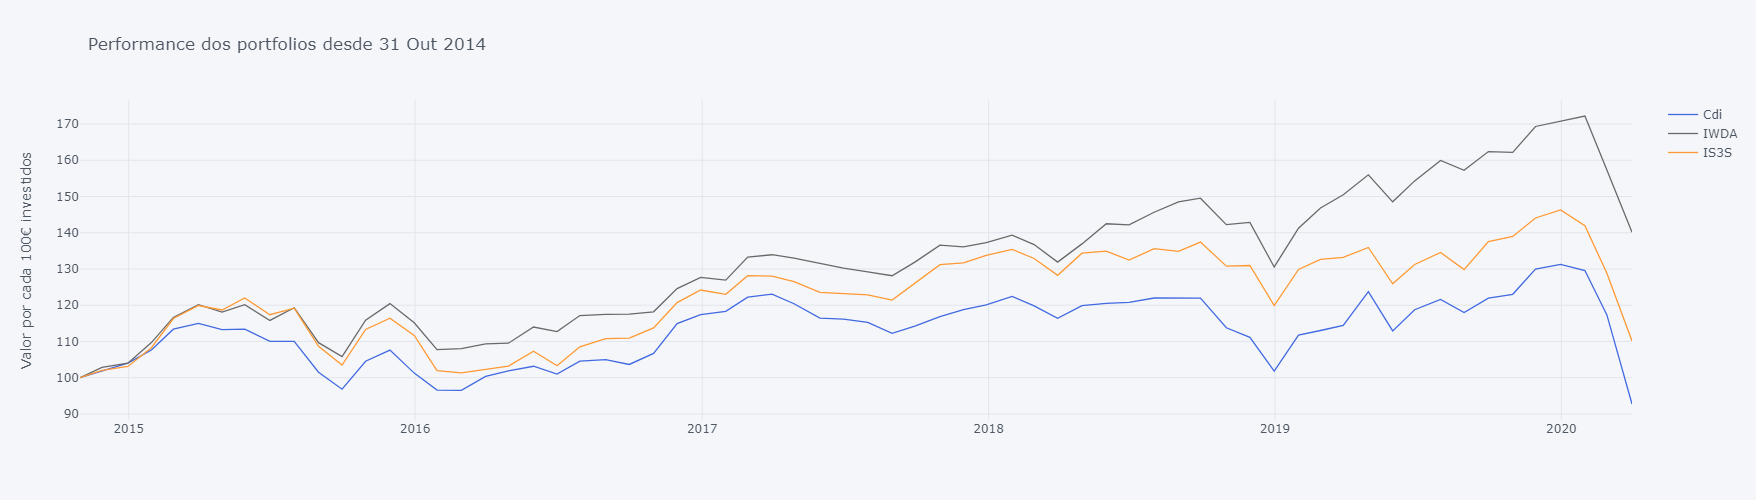

In [29]:
round(fundos_norm, 2).iplot(yTitle='Valor por cada 100€ investidos', title='Performance dos portfolios desde 31 Out 2014',
                           colors=['royalblue', 'dimgray', 'orange'], dimensions=dimensions)

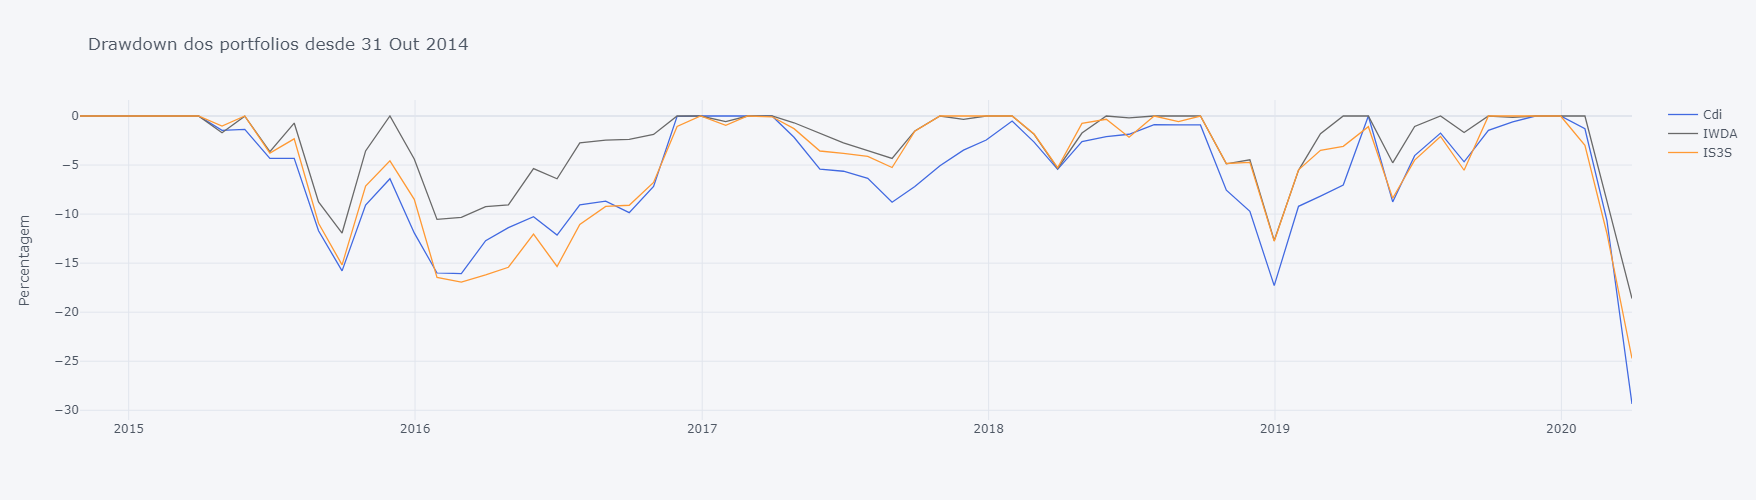

In [31]:
#### Computing Drawdowns ####
DD = round(compute_drawdowns(fundos_norm), 2)

DD.iplot(kind='scatter', title='Drawdown dos portfolios desde 31 Out 2014', yTitle='Percentagem', colors=['royalblue', 'dimgray', 'orange'], dimensions=dimensions)

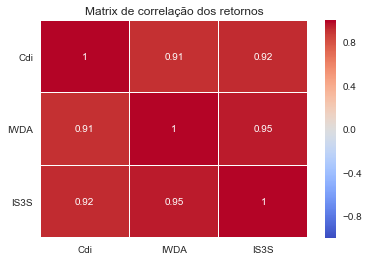

In [32]:
#### Returns ####
returns = (fundos_norm / fundos_norm.shift(1)) - 1

# Correlation Matrix
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)

sns.heatmap(returns.corr(), annot=True, cmap="coolwarm", linewidths=.2, vmin = -1, vmax = 1, cbar=True, center=0)
plt.yticks(rotation=360)
plt.title('Matrix de correlação dos retornos')
plt.show()

### Valores de R quadrado (Coeficiente de determinação) da Casa de Investimentos

In [33]:
compute_r2_table(fundos_norm, fundos_norm['Cdi'])

,Cdi,IWDA,IS3S
Cdi,1.0,0.606,0.812


### Tabela de performance desde 31 Out 2014

In [34]:
compute_performance_table(fundos_norm, freq='months')

,CAGR,StdDev,Sharpe,Max DD,MAR
Cdi,-1.38%,15.47%,-0.09,-29.36%,-0.05
IWDA,6.42%,12.92%,0.50,-18.61%,0.35
IS3S,1.80%,14.47%,0.12,-24.72%,0.07


- **CAGR:** Retorno geométrico anualizado do portfolio;
- **StdDev:** Desvio padrão anualizado do portfolio (quanto mais alto mais risco tem a carteira);
- **Sharpe:** CAGR/StdDev (quanto mais alto melhor);
- **Max DD:** Maior queda do portfolio;
- **MAR:** CAGR/Max DD (quanto mais alto melhor).

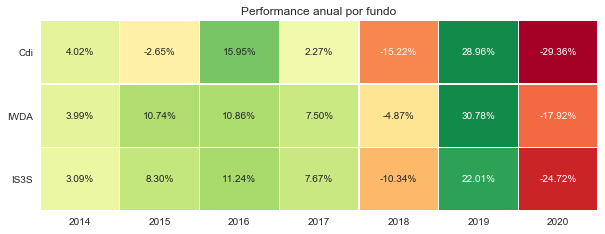

In [35]:
# Resampling to yearly (business year)
yearly_quotes_fundos = fundos_norm.resample('BA').last()

# Adding first quote (only if start is in the middle of the year) ### Falta trabalho para automatizar #####
yearly_quotes_fundos = pd.concat([fundos_norm.iloc[:1], yearly_quotes_fundos])

# Returns
yearly_returns_fundos = ((yearly_quotes_fundos / yearly_quotes_fundos.shift(1)) - 1) * 100
yearly_returns_fundos = yearly_returns_fundos.set_index([list(range(fundos_norm.index[0].year - 1, fundos_norm.index[-1].year + 1))]).drop(fundos_norm.index[0].year - 1)

# Inverter o sentido das rows no dataframe ####
yearly_returns_fundos = yearly_returns_fundos / 100 # A alterar para incluir 2001

# Sns heatmap
fig, ax = plt.subplots()
fig.set_size_inches(10, 3.5)

ax = sns.heatmap(yearly_returns_fundos.transpose(), annot=True, cmap="RdYlGn", linewidths=.2, cbar=False, center=0, fmt='.2%', vmax=0.25)
plt.yticks(rotation=360)
plt.title('Performance anual por fundo')
plt.show()

Performance de 2014 só diz respeito ao periodo após 31 Out 2014.

### One year performance

In [36]:
one_year = filter_by_date(fundos_norm, years=1, previous_row=False)
compute_performance_table(one_year, freq='months')

,CAGR,StdDev,Sharpe,Max DD,MAR
Cdi,-26.83%,27.64%,-0.97,-29.36%,-0.91
IWDA,-10.93%,18.05%,-0.61,-18.61%,-0.59
IS3S,-20.38%,22.34%,-0.91,-24.72%,-0.82


### Three year performance

In [37]:
three_years = filter_by_date(fundos_norm, years=3)
compute_performance_table(three_years, freq='months')

,CAGR,StdDev,Sharpe,Max DD,MAR
Cdi,-8.99%,16.95%,-0.53,-29.36%,-0.31
IWDA,1.52%,12.55%,0.12,-18.61%,0.08
IS3S,-4.89%,14.10%,-0.35,-24.72%,-0.20


### Five year performance

In [38]:
five_years = filter_by_date(fundos_norm, years=5)
compute_performance_table(five_years, freq='months')

,CAGR,StdDev,Sharpe,Max DD,MAR
Cdi,-4.20%,15.73%,-0.27,-29.36%,-0.14
IWDA,3.12%,12.89%,0.24,-18.61%,0.17
IS3S,-1.69%,14.44%,-0.12,-24.72%,-0.07


### Tabela de drawdowns da Casa de Investimentos

In [39]:
compute_drawdowns_table(fundos_norm['Cdi'])

,Begin,End,Depth,Length
1,2019-12-31,NaT,-29.36%,"0 Years, 3 Months, 0 Days"
2,2017-03-31,2019-04-30,-17.29%,"2 Years, 0 Months, 30 Days"
3,2015-03-31,2016-12-30,-16.07%,"1 Years, 8 Months, 29 Days"
4,2019-04-30,2019-11-29,-8.76%,"0 Years, 6 Months, 30 Days"
5,2014-10-31,2014-11-28,0.0%,"0 Years, 0 Months, 28 Days"


### Tabela de drawdowns do IWDA

In [40]:
compute_drawdowns_table(fundos_norm['IWDA'])

,Begin,End,Depth,Length
1,2020-01-31,NaT,-18.61%,"0 Years, 2 Months, 0 Days"
2,2018-09-28,2019-03-29,-12.69%,"0 Years, 6 Months, 1 Days"
3,2015-03-31,2015-11-30,-11.93%,"0 Years, 7 Months, 30 Days"
4,2015-11-30,2016-11-30,-10.54%,"1 Years, 0 Months, 0 Days"
5,2018-01-31,2018-05-31,-5.35%,"0 Years, 4 Months, 0 Days"


### Tabela de drawdowns do IS3S

In [41]:
compute_drawdowns_table(fundos_norm['IS3S'])

,Begin,End,Depth,Length
1,2019-12-31,NaT,-24.72%,"0 Years, 3 Months, 0 Days"
2,2015-05-29,2016-12-30,-16.94%,"1 Years, 7 Months, 1 Days"
3,2018-09-28,2019-09-30,-12.76%,"1 Years, 0 Months, 2 Days"
4,2018-01-31,2018-07-31,-5.27%,"0 Years, 6 Months, 0 Days"
5,2017-02-28,2017-10-31,-5.25%,"0 Years, 8 Months, 3 Days"


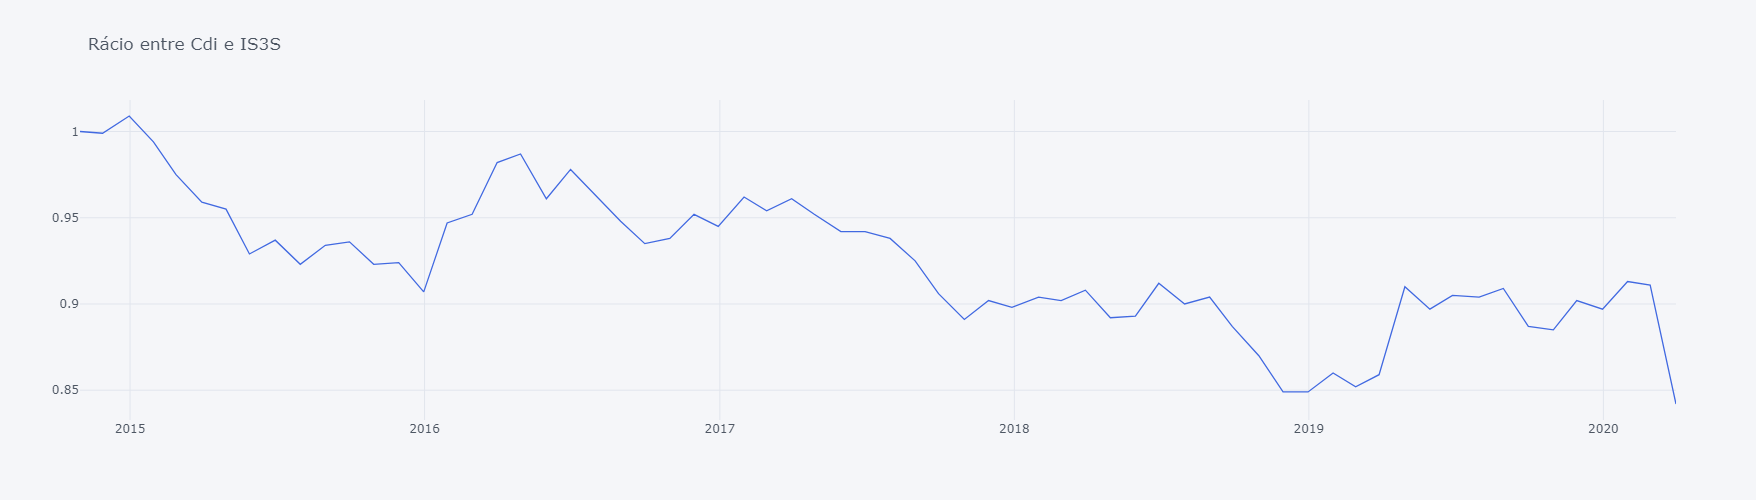

In [42]:
round(fundos_norm['Cdi'] / fundos_norm['IS3S'], 3).iplot(yTitle='', title='Rácio entre Cdi e IS3S',  colors=['royalblue', 'orange', 'dimgray'], dimensions = dimensions)

##### Valores mais baixo underperformance da casa de investimento face ao IS3S.

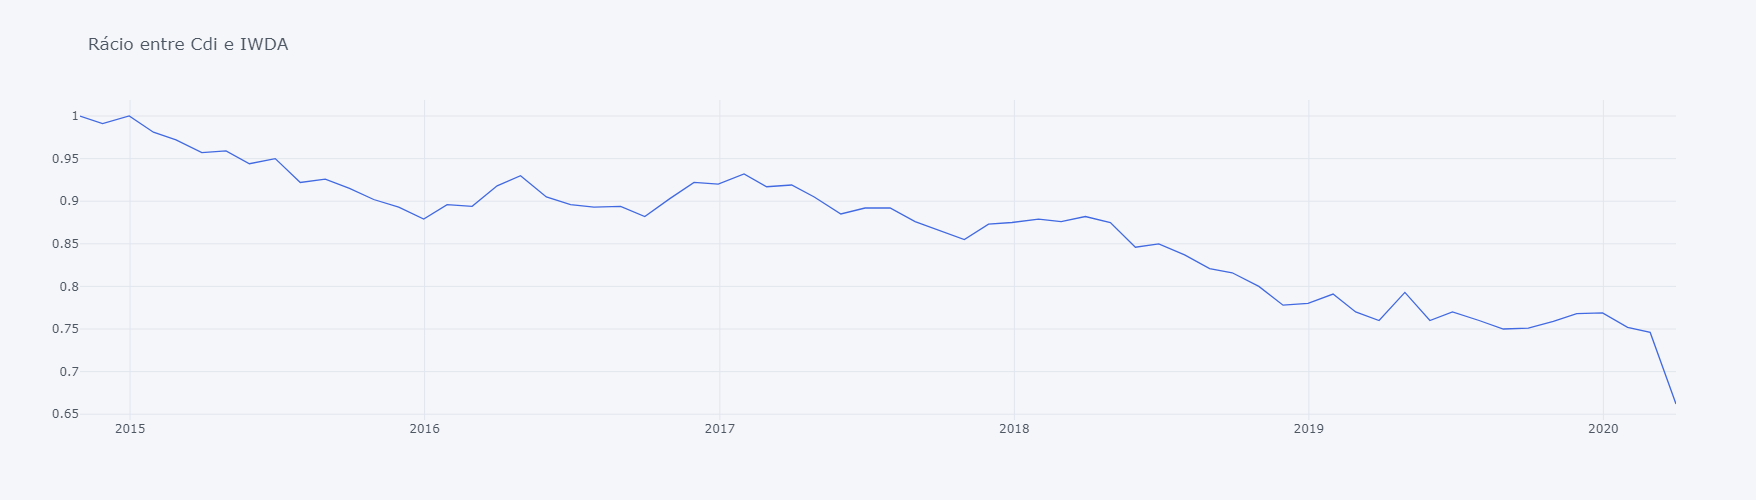

In [43]:
round(fundos_norm['Cdi'] / fundos_norm['IWDA'], 3).iplot(yTitle='', title='Rácio entre Cdi e IWDA',  colors=['royalblue', 'orange', 'dimgray'], dimensions = dimensions)

##### Descidas a favor do IWDA e subidas a favor da casa de investimentos

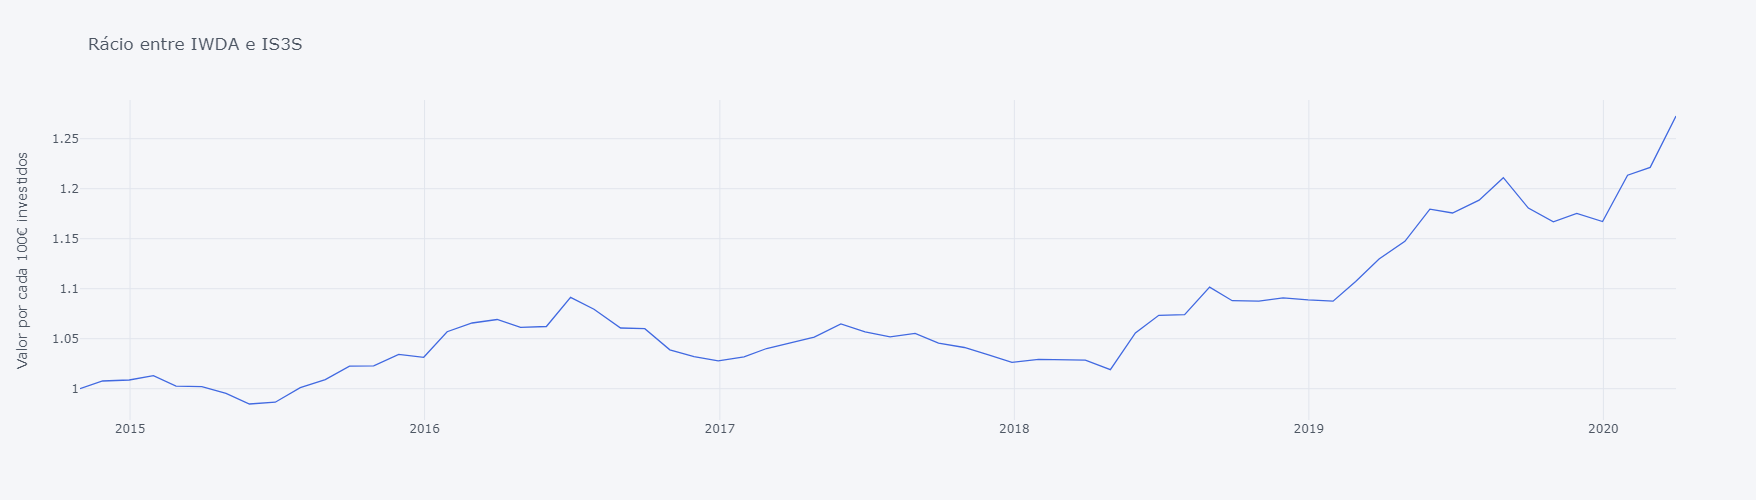

In [44]:
round(fundos_norm['IWDA'] / fundos_norm['IS3S'], 4).iplot(yTitle='Valor por cada 100€ investidos', title='Rácio entre IWDA e IS3S',  colors=['royalblue', 'orange', 'dimgray'], dimensions = dimensions)

##### Valores mais alto overperformance do IWDA face ao IS3S.

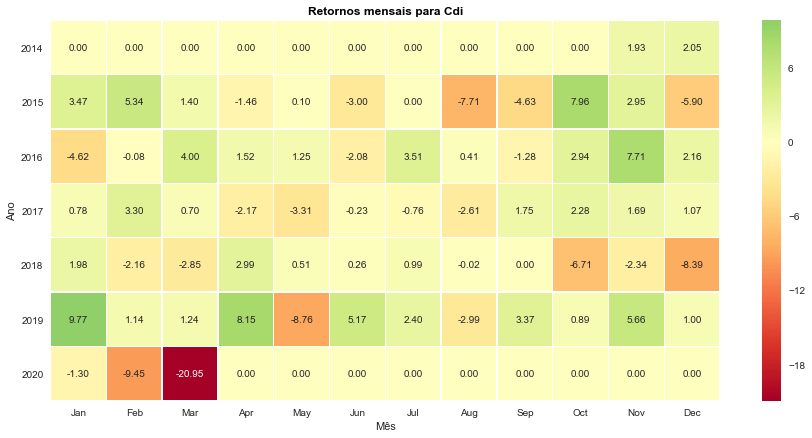

In [53]:
fundos=fundos_norm.copy()

# Compute monthly returns table
nr = 0

plot(fundos.iloc[:, nr], title= 'Retornos mensais para ' + fundos.iloc[:, nr].name , figsize=(15, len(np.unique(fundos.index.year))))

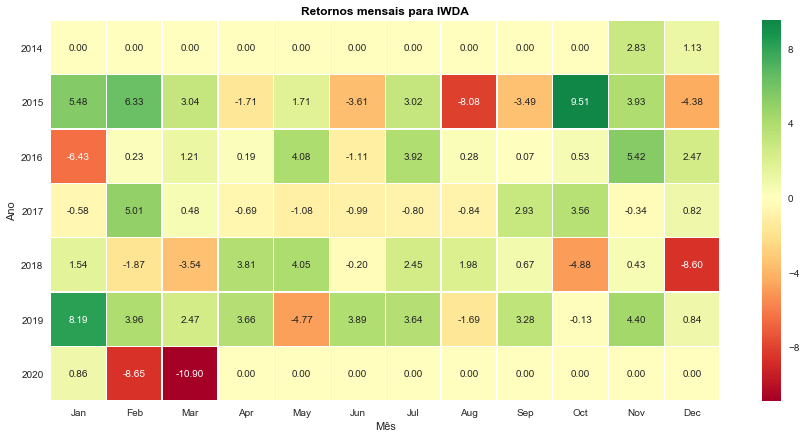

In [54]:
# Compute monthly returns table
nr = 1

plot(fundos.iloc[:, nr], title= 'Retornos mensais para ' + fundos.iloc[:, nr].name , figsize=(15, len(np.unique(fundos.index.year))))

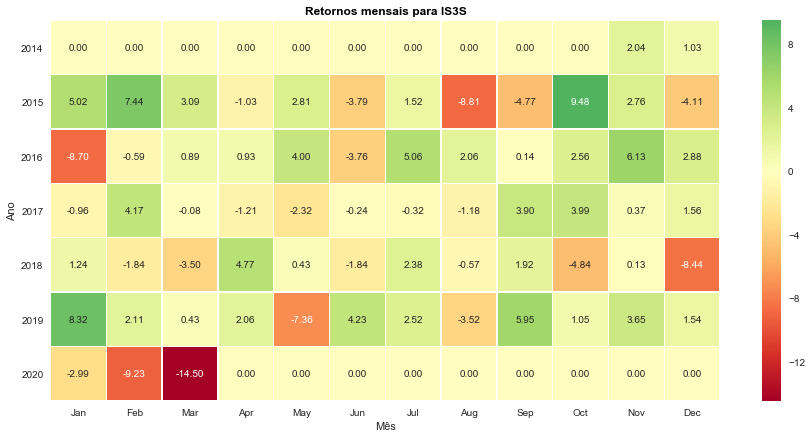

In [55]:
# Compute monthly returns table
nr = 2

plot(fundos.iloc[:, nr], title= 'Retornos mensais para ' + fundos.iloc[:, nr].name , figsize=(15, len(np.unique(fundos.index.year))))

In [45]:
#### Análise de curto prazo, desde junho de 2017

In [46]:
# # Data de começo da análise
# fundos_2 = fundos.loc['2017-06-30':]

In [47]:
# #### Normalization to 100 ####
# fundos_norm_cp = (fundos_2 / fundos_2.iloc[0] * 100)

In [48]:
# round(fundos_norm_cp, 2).iplot(yTitle='Valor por cada 100€ investidos', title='Performance dos portfolios', colors=['royalblue', 'orange', 'dimgray'])

In [49]:
# #### Computing Drawdowns ####
# DD = round(compute_drawdowns(fundos_norm_cp), 2)

# DD.iplot(kind='scatter', title='Drawdown dos portfolios', yTitle='Percentagem', colors=['royalblue', 'orange', 'dimgray'])

In [50]:
###### Performance de curto prazo (lembrar que os valores são anualizados, não os efectivos)

In [51]:
# compute_performance_table(fundos_norm_cp, freq='months').transpose()